In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.tri as tri

from pathlib import Path
from torch.distributions import Dirichlet,Categorical,Multinomial

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer

from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig


In [2]:
from conditional_rate_matching import plots_path
plots_path = plots_path / "ramses_mjp_distance"
plots_path

WindowsPath('C:/Users/cesar/Desktop/Projects/DiffusiveGenerativeModelling/Codes/conditional_rate_matching/plots/ramses_mjp_distance')

## Histograms Plots / Paths Samples

In [3]:
def categorical_counts_per_path(x_path,dimensions=3,vocab_size=3,normalize=True):
    """
    parameters
    ----------
    x_path: torch.Tensor

    return
    ------
    sample_size,paths_counts
    """
    sample_size = x_path.shape[0]
    number_of_steps = x_path.shape[1]
    dimensions = x_path.shape[2]

    paths_counts = F.one_hot(x_path.long(),num_classes=vocab_size).sum(axis=0)
    if normalize:
        paths_counts = paths_counts/sample_size
    return paths_counts

def get_conditional_histograms_paths(crm,t_path,num_timesteps_to_plot=None):
    vocab_size = crm.config.data1.vocab_size
    dimensions = crm.config.data1.dimensions
    number_of_steps = t_path.shape[0]
    # Generate indices for the timesteps to plot

    if num_timesteps_to_plot is not None:
        if num_timesteps_to_plot >= number_of_steps:
            indices = range(number_of_steps)
        else:
            indices = np.linspace(0, number_of_steps - 1, num=num_timesteps_to_plot, dtype=int)
    else:
        indices = range(number_of_steps)
        num_timesteps_to_plot = number_of_steps
        
    times_to_plot = t_path[indices]
    conditional_histograms_paths = torch.zeros((num_timesteps_to_plot,dimensions,vocab_size))

    sample_size = 0
    crm_dataloader = CRMDataloder(crm.dataloader_0,crm.dataloader_1)
    for databatch in crm_dataloader.train():
        batch_0, batch_1 = databatch    
        # data pair and time sample
        x_1, x_0 = crm.sample_pair(batch_1,batch_0,crm.device)
        batch_size = x_1.shape[0]

        for time_index, time in enumerate(times_to_plot.detach().numpy()):
            time = torch.full((batch_size,),time)
            sampled_x = crm.forward_rate.sample_x(x_1, x_0, time)
            counts_in_sample = F.one_hot(sampled_x,num_classes=vocab_size).sum(axis=0)
            conditional_histograms_paths[time_index] += counts_in_sample
        sample_size += batch_size
        
    conditional_histograms_paths = conditional_histograms_paths/sample_size
    return conditional_histograms_paths

In [4]:
def categorical_histogram_dataloader(dataloader_0, dimensions, number_of_classes, train=True,maximum_test_sample_size = 2000):
    """
    Just the marginal per dimension

    :param dataloader_0:
    :param dimensions:
    :param number_of_classes:
    :param train:
    :return:
    """
    if hasattr(dataloader_0, "train"):
        if train:
            dataloader = dataloader_0.train()
        else:
            dataloader = dataloader_0.test()
    else:
        dataloader = dataloader_0

    histogram = torch.zeros(dimensions,number_of_classes)
    if dataloader is None:
        return histogram

    sample_size = 0.
    for databatch in dataloader:
        x_0 = databatch[0]
        if len(x_0.shape) > 2:
            batch_size = x_0.size(0)
            x_0 = x_0.reshape(batch_size,-1)
        sample_size += x_0.size(0)
        histogram += F.one_hot(x_0.long(),num_classes=number_of_classes).sum(axis=0)
        if sample_size > maximum_test_sample_size:
            break
    histogram = histogram / sample_size
    return histogram

In [5]:
def create_histograms_paths(simplex_distribution_a,simplex_distribution_b=None,gamma=1.,t_path_=None):
    if t_path_ is None:
        t_path_ = torch.linspace(0.,1.,100)

    vocab_size = simplex_distribution_a.squeeze().shape[0]
    config = CRMConfig()
    config.thermostat = ConstantThermostatConfig(gamma=gamma)
    config.data1 = StatesDataloaderConfig(dimensions=1,
                                          vocab_size=vocab_size,
                                          bernoulli_probability=simplex_distribution_a,
                                          total_data_size=1000,
                                          test_split=0.1)
    
    if simplex_distribution_b is not None:
        config.data0 = StatesDataloaderConfig(dimensions=1,
                                            vocab_size=vocab_size,
                                            bernoulli_probability=simplex_distribution_b,
                                            total_data_size=1000,
                                            test_split=0.1)

    crm_a = CRM(config=config)
    conditional_histograms_paths = get_conditional_histograms_paths(crm_a,t_path_)
    return conditional_histograms_paths

In [6]:
def plot_time_series_histograms(data, data2=None,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None):
    """
    Plots a series of histograms from a 3D PyTorch tensor, ensuring the first
    and last timesteps are always included in the plot.

    Parameters:
    data (torch.Tensor): A tensor of shape (number_of_steps, dimensions, vocab_size)
    num_timesteps_to_plot (int): Number of timesteps to plot, including the first and last timesteps

    """
    number_of_steps, dimensions, vocab_size = data.shape
    
    # Generate indices for the timesteps to plot
    if num_timesteps_to_plot >= number_of_steps:
        indices = range(number_of_steps)
    else:
        indices = np.linspace(0, number_of_steps - 1, num=num_timesteps_to_plot, dtype=int)
    
    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(nrows=dimensions, ncols=len(indices), figsize=figsize_tuple)
    
    # Make sure axes is always 2D
    if dimensions == 1:
        axes = axes.reshape((1, -1))
    if len(indices) == 1:
        axes = axes.reshape((-1, 1))
    
    # Plot each dimension and timestep
    for i in range(dimensions):
        for j, idx in enumerate(indices):
            ax = axes[i, j]
            ax.bar(range(vocab_size), data[idx, i].numpy(), color='blue',alpha=0.4)
            if data2 is not None:
                ax.bar(range(vocab_size), data2[j, i].numpy(), color='red',alpha=0.4)
            ax.set_title(f"t = {idx+1}")
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
            ax.set_ylim(0,1)

    
    plt.tight_layout()
    if plot_path is not None:
        plt.savefig(plots_path/plot_path)
    plt.show()
    return indices

In [7]:
def plot_histograms_pairs(stationary_0,stationary_1,hist0=None,hist1=None):
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12, 3))

    stationary_0_ = stationary_0.squeeze().detach().numpy()
    stationary_1_ = stationary_1.squeeze().detach().numpy()

    if hist0 is not None:
        axs[0].bar(range(len(hist0)), hist0, color='blue',alpha=0.3,label="sim")
    axs[0].bar(range(len( stationary_0_)), stationary_0_, color='green',alpha=0.3,label="target0")
    axs[0].set_ylim(0,1)
    axs[0].legend(loc="best")

    if hist1 is not None:
        axs[1].bar(range(len(hist1)), hist1, color='red',alpha=0.3,label="sim")
    axs[1].bar(range(len( stationary_1_)), stationary_1_,color='green',alpha=0.3,label="target0")
    axs[1].set_ylim(0,1)
    axs[1].legend(loc="best")
    plt.show()

def sample_events_from_dirichlet(vocab_size,dirichlet_alpha,number_of_samples=300):
    simplex_distribution = Dirichlet(torch.full((vocab_size,),dirichlet_alpha))
    simplex_point = simplex_distribution.sample((1,))
    events_distribution = Categorical(simplex_point)
    events = events_distribution.sample((number_of_samples,))
    return simplex_point.squeeze(),events    

In [8]:
def create_points_in_the_simplex(n=100):
    # Create a grid on the simplex
    t = np.linspace(0, 1, n)
    X, Y = np.meshgrid(t, t)
    X = X.flatten()
    Y = Y.flatten()
    Z = 1 - X - Y
    simplex_points = np.vstack((X, Y, Z)).T
    simplex_points = simplex_points[np.all(simplex_points >= 0, axis=1)]
    return simplex_points

In [9]:
def simplex_plot(simplex_points,values,plot_name=None):
    # Triangular mesh for the simplex
    triangulation = tri.Triangulation(simplex_points[:, 0], simplex_points[:, 1])

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'aspect': 'equal'})
    tpc = ax.tripcolor(triangulation, values, shading='flat', cmap='viridis')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, np.sqrt(0.75)])
    ax.set_title(f'Simplex Visualization Hellinger Distance')
    fig.colorbar(tpc, ax=ax, label='Value')

    # Hide the axes for clarity
    ax.axis('off')
    if plot_name is not None:
        plt.savefig(plots_path / plot_name)

In [10]:
def get_path_entropy(conditional_histograms_paths_,per_dimension=True):
    assert conditional_histograms_paths_.max().item() <= 1.
    assert conditional_histograms_paths_.min().item() >= 0.
    where_zero = torch.where(conditional_histograms_paths_ == 0.)
    entropy = -conditional_histograms_paths_*torch.log(conditional_histograms_paths_)
    entropy[where_zero] = 0.
    entropy = entropy.sum(axis=-1)
    if not per_dimension:
        entropy = entropy.mean(axis=1)
    return entropy

In [11]:
def hellinger_distance_function(hist1, hist2):
    """
    Compute the Hellinger distance between two histograms.

    Args:
    hist1 (torch.Tensor): Histogram of the first distribution.
    hist2 (torch.Tensor): Histogram of the second distribution.

    Returns:
    float: Hellinger distance between the two histograms.
    """
    # Compute the square root of each bin
    sqrt_hist1 = torch.sqrt(hist1)
    sqrt_hist2 = torch.sqrt(hist2)

    # Compute the Euclidean distance between the square-rooted histograms
    euclidean_distance = torch.norm(sqrt_hist1 - sqrt_hist2, 2)

    # Normalize to get the Hellinger distance
    hellinger_distance = euclidean_distance / 2.

    return hellinger_distance

## Select End Distributions

In [12]:
vocab_size = 3
dimensions = 1
number_of_samples = 300
dirichlet_alpha = 0.2

simplex_distribution_a,events_a = sample_events_from_dirichlet(vocab_size,dirichlet_alpha,number_of_samples=300)
simplex_distribution_b,events_b = sample_events_from_dirichlet(vocab_size,dirichlet_alpha,number_of_samples=300)
simplex_uniform = torch.ones((vocab_size))/vocab_size
simplex_uniform

tensor([0.3333, 0.3333, 0.3333])

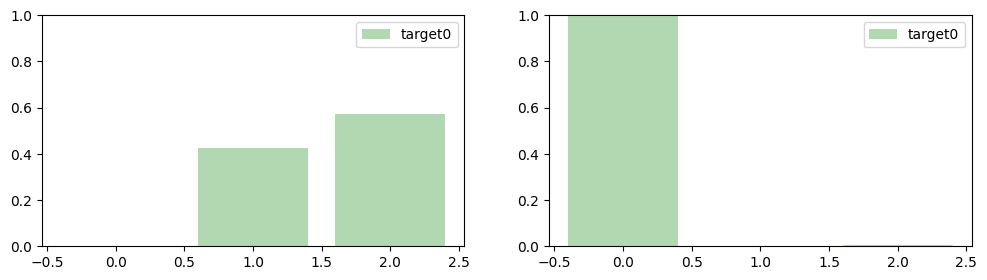

In [13]:
plot_histograms_pairs(simplex_distribution_a,simplex_distribution_b,hist0=None,hist1=None)

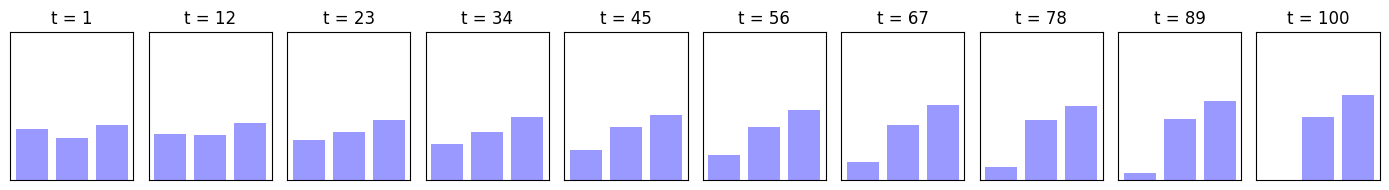

In [14]:
gamma = 0.1
t_path_ = torch.linspace(0.,1.,100)

plot_name = f"reference_histogram_{gamma}.png"
conditional_histograms_paths_reference = create_histograms_paths(simplex_distribution_a,
                                                                 simplex_distribution_b=None,
                                                                 gamma=gamma,
                                                                 t_path_=t_path_)
indices = plot_time_series_histograms(conditional_histograms_paths_reference, num_timesteps_to_plot=10,figsize_tuple=(14,2),plot_path=plot_name)

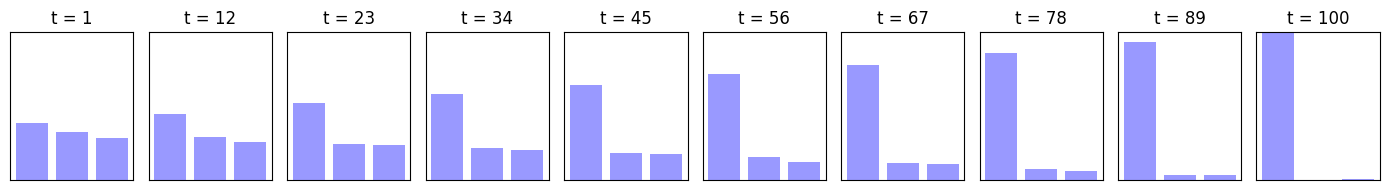

In [16]:
plot_name = f"simplex_example_histogram_{gamma}.png"
conditional_histograms_paths_ = create_histograms_paths(simplex_distribution_b,
                                                        simplex_distribution_b=None,
                                                        gamma=gamma,
                                                        t_path_=t_path_)
indices = plot_time_series_histograms(conditional_histograms_paths_, num_timesteps_to_plot=10,figsize_tuple=(14,2),plot_path=plot_name)

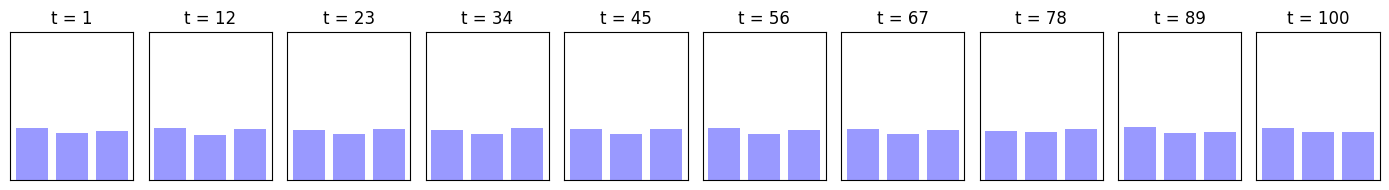

In [17]:
null_path = create_histograms_paths(simplex_uniform,
                                    simplex_distribution_b=None,
                                    gamma=gamma,
                                    t_path_=t_path_)
indices = plot_time_series_histograms(null_path, num_timesteps_to_plot=10,figsize_tuple=(14,2),plot_path=None)

In [19]:
path_entropy_reference = get_path_entropy(conditional_histograms_paths_reference,per_dimension=False)
path_entropy = get_path_entropy(conditional_histograms_paths_,per_dimension=False)

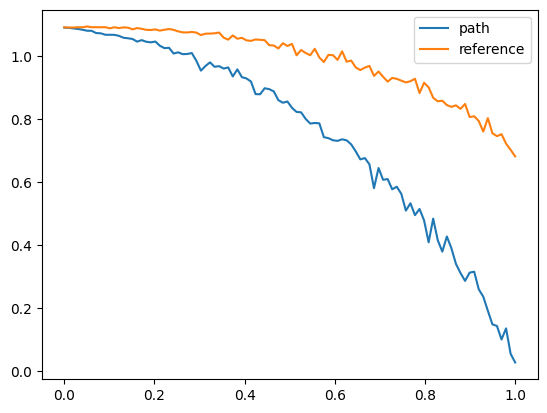

In [20]:
plot_name = f"entropy_reference_vs_example_{gamma}.png"
plt.plot(t_path_,path_entropy,label="path")
plt.plot(t_path_,path_entropy_reference,label="reference")
plt.legend(loc="best")
plt.savefig(plots_path / plot_name)

In [51]:
hellinger_distance_function(conditional_histograms_paths_,conditional_histograms_paths_reference)

tensor(1.5551)

In [21]:
simplex_points = create_points_in_the_simplex(10)
print(f"Point in Simplex {simplex_points.shape[0]}")

hd_n = hellinger_distance_function(conditional_histograms_paths_,null_path)
values = []
for simplex_index,simplex_point in enumerate(simplex_points):
    simplex_point = torch.Tensor(simplex_point)
    conditional_histograms_paths_ = create_histograms_paths(simplex_point,
                                                            simplex_distribution_b=None,
                                                            gamma=10.,
                                                            t_path_=None)
    hd = hellinger_distance_function(conditional_histograms_paths_, conditional_histograms_paths_reference)
    hd = hd /hd_n
    values.append(hd)
    if simplex_index % 10 == 0:
        print(simplex_index)
values = np.asarray([v.item() for v in values])

Point in Simplex 55
0
10
20
30
40
50


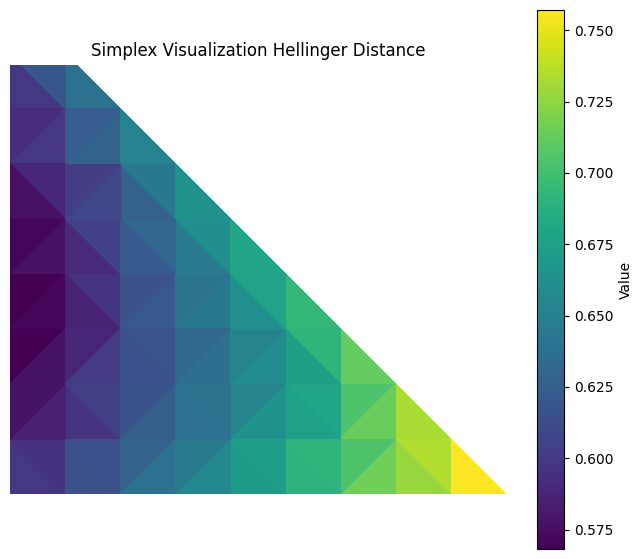

In [22]:
simplex_plot_name = f"simplex_{gamma}.png"
simplex_plot(simplex_points,values,simplex_plot_name)